# Study single material point stress redistribution

In [1]:
import os
import matplotlib
from bmcs_matmod.ms1.Micro2Dplot import Micro2Dplot
from bmcs_matmod.ms1.vmats2D_mpl_csd_eeq import MATS2DMplCSDEEQ
import bmcs_matmod.ms1.concrete_material_db as cdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def get_eps_ab(eps_O):

    eps_ab = np.zeros((2, 2))
    eps_ab[0, 0] = eps_O[0]
    eps_ab[0, 1] = eps_O[2]
    eps_ab[1, 0] = eps_O[2]
    eps_ab[1, 1] = eps_O[1]

    return eps_ab


def get_sig_O(sig_ab):

    sig_O = np.zeros((3, 1))
    sig_O[0] = sig_ab[0, 0]
    sig_O[1] = sig_ab[1, 1]
    sig_O[2] = sig_ab[1, 0]

    return sig_O


def get_K_OP(D_abcd):

    K_OP = np.zeros((3, 3))

    K_OP[0, 0] = D_abcd[0, 0, 0, 0]
    K_OP[0, 1] = D_abcd[0, 0, 1, 1]
    K_OP[0, 2] = 2 * D_abcd[0, 0, 0, 1]

    K_OP[1, 0] = D_abcd[1, 1, 0, 0]
    K_OP[1, 1] = D_abcd[1, 1, 1, 1]
    K_OP[1, 2] = 2 * D_abcd[1, 1, 0, 1]

    K_OP[2, 0] = D_abcd[0, 1, 0, 0]
    K_OP[2, 1] = D_abcd[0, 1, 1, 1]
    K_OP[2, 2] = 2 * D_abcd[0, 1, 0, 1]

    return K_OP

# Monotnic behavior

In [3]:
def get_UF_t(time_function, n_t):


    int_var = np.zeros((n_mp, 21))
    int_var_aux = np.zeros((n_mp, 21))
    dissip = np.zeros((n_mp, 8))
    save = np.concatenate((int_var, dissip), axis=1)
    # df = pd.DataFrame(save)
    # df.to_hdf(path, 'first', mode='w', format='table')

    # total number of DOFs
    n_O = 3
    # Global vectors
    F_ext = np.zeros((n_O,), np.float_)
    F_O = np.zeros((n_O,), np.float_)
    U_P = np.zeros((n_O,), np.float_)
    U_k_O = np.zeros((n_O,), dtype=np.float_)
    eps_aux = get_eps_ab(U_k_O)
    # Construct index maps distinguishing the controlled displacements
    # and free displacements. Here we simply say the the control displacement
    # is the first one. Then index maps are constructed using the np.where
    # function returning the indexes of True positions in a logical array.
    CONTROL = 0
    FREE = slice(1, None)  # This means all except the first index, i.e. [1:]
    # Setup the system matrix with displacement constraints
    # Time stepping parameters
    t_n1, t_max, t_step = 0, len(time_function), 1 / n_t
    t_n = 0
    # Iteration parameters
    k_max, R_acc = 1000, 1e-5
    # Record solutions
    U_t_list, F_t_list, U_P_list = [np.copy(U_k_O)], [np.copy(F_O)], [np.copy(U_P)]
    D = np.zeros((2, 2, 2, 2))
    D = D[np.newaxis, :, :, :, :]

    # Load increment loop
    while t_n1 <= t_max - 1:
        #print('t:', t_n1)
        # Get the displacement increment for this step
        delta_U = time_function[t_n1] - time_function[t_n]
        k = 0
        # Equilibrium iteration loop
        while k < k_max:
            # Transform the primary vector to field
            eps_ab = get_eps_ab(U_k_O)
            # Stress and material stiffness
            D_abcd, sig_ab, eps_p_Emab = m.get_corr_pred(
                eps_ab, 1, int_var, eps_aux, F_ext
            )
            # Internal force
            F_O = get_sig_O(sig_ab).reshape(3,)
            U_P = get_sig_O(eps_p_Emab).reshape(3, )
            # System matrix
            K_OP = get_K_OP(D_abcd)
            # Get the balancing forces - NOTE - for more displacements
            # this should be an assembly operator.
            # KU remains a 2-d array so we have to make it a vector
            KU = K_OP[:, CONTROL] * delta_U
            # Residuum
            R_O = F_ext - F_O - KU
            # Convergence criterion
            R_norm = np.linalg.norm(R_O[FREE])
            # print(R_O)
            # print(R_O[FREE])
            # Next iteration -
            delta_U_O = np.linalg.solve(K_OP[FREE, FREE], R_O[FREE])
            # Update total displacement
            U_k_O[FREE] += delta_U_O
            # Update control displacement
            U_k_O[CONTROL] = U_k_O[CONTROL] + delta_U
            if R_norm < R_acc:
                # Convergence reached
                break
            # Note - control displacement nonzero only in the first iteration.
            delta_U = 0
            k += 1
        else:
            print('no convergence')
            break

        # Update states variables after convergence
        int_var = m._get_state_variables(eps_ab, int_var, eps_aux)

        # Definition internal variables / forces per column:  1) damage N, 2)iso N, 3)kin N, 4) consolidation N, 5) eps p N,
        # 6) sigma N, 7) iso F N, 8) kin F N, 9) energy release N, 10) damage T, 11) iso T, 12-13) kin T, 14-15) eps p T,
        # 16-17) sigma T, 18) iso F T, 19-20) kin F T, 21) energy release T

        # Definition dissipation components per column: 1) damage N, 2) damage T, 3) eps p N, 4) eps p T, 5) iso N
        # 6) iso T, 7) kin N, 8) kin T

        dissip[:, 0] += np.einsum('...n,...n->...n', int_var[:, 0] - int_var_aux[:, 0], int_var[:, 8])
        dissip[:, 1] += np.einsum('...n,...n->...n', int_var[:, 9] - int_var_aux[:, 9], int_var[:, 20])
        dissip[:, 2] += np.einsum('...n,...n->...n', int_var[:, 4] - int_var_aux[:, 4], int_var[:, 5])
        dissip[:, 3] += np.einsum('...n,...n->...', int_var[:, 13:15] - int_var_aux[:, 13:15], int_var[:, 15:17])
        dissip[:, 4] += np.einsum('...n,...n->...n', int_var[:, 1] - int_var_aux[:, 1], int_var[:, 6])
        dissip[:, 5] += np.einsum('...n,...n->...n', int_var[:, 10] - int_var_aux[:, 10], int_var[:, 17])
        dissip[:, 6] += np.einsum('...n,...n->...n', int_var[:, 2] - int_var_aux[:, 2], int_var[:, 7])
        dissip[:, 7] += np.einsum('...n,...n->...', int_var[:, 11:13] - int_var_aux[:, 11:13], int_var[:, 18:20])

        int_var_aux = int_var * 1

        save = np.concatenate((int_var, dissip), axis=1)

        df = pd.DataFrame(save)
        df.to_hdf(path, 'middle' + np.str(t_n1), append=True)

        U_t_list.append(np.copy(U_k_O))
        F_t_list.append(F_O)
        U_P_list.append(U_P)
        eps_aux = get_eps_ab(U_k_O)
        D_aux = D_abcd[np.newaxis, :, :, :, :]
        D = np.concatenate((D, D_aux))
        t_n = t_n1
        t_n1 += 1

    U_t, F_t, U_p = np.array(U_t_list), np.array(F_t_list),np.array(U_P_list)
    return U_t, F_t, D, U_p

In [4]:
def get_int_var(path, size, n_mp):  # unpacks saved data

    S = np.zeros((len(F), n_mp, 29))

    # S[0] = np.array(pd.read_hdf(path, 'first'))

    for i in range(1, size):
        # print(S[i].shape)
        S[i] = np.array(pd.read_hdf(path, 'middle' + np.str(i - 1)))

    omega_N_Emn = S[:, :, 0]
    z_N_Emn = S[:, :, 1]
    alpha_N_Emn = S[:, :, 2]
    r_N_Emn = S[:, :, 3]
    eps_N_p_Emn = S[:, :, 4]
    sigma_N_Emn = S[:, :, 5]
    Z_N_Emn = S[:, :, 6]
    X_N_Emn = S[:, :, 7]
    Y_N_Emn = S[:, :, 8]

    omega_T_Emn = S[:, :, 9]
    z_T_Emn = S[:, :, 10]
    alpha_T_Emna = S[:, :, 11:13]
    eps_T_pi_Emna = S[:, :, 13:15]
    sigma_T_Emna = S[:, :, 15:17]
    Z_T_pi_Emn = S[:, :, 17]
    X_T_pi_Emna = S[:, :, 18:20]
    Y_T_pi_Emn = S[:, :, 20]

    Disip_omena_N_Emn = S[:, :, 21]
    Disip_omena_T_Emn = S[:, :, 22]
    Disip_eps_p_N_Emn = S[:, :, 23]
    Disip_eps_p_T_Emn = S[:, :, 24]
    Disip_iso_N_Emn = S[:, :, 25]
    Disip_iso_T_Emn = S[:, :, 26]
    Disip_kin_N_Emn = S[:, :, 27]
    Disip_kin_T_Emn = S[:, :, 28]

    return omega_N_Emn, z_N_Emn, alpha_N_Emn, r_N_Emn, eps_N_p_Emn, sigma_N_Emn, Z_N_Emn, X_N_Emn, Y_N_Emn, \
           omega_T_Emn, z_T_Emn, alpha_T_Emna, eps_T_pi_Emna, sigma_T_Emna, Z_T_pi_Emn, X_T_pi_Emna, Y_T_pi_Emn, \
           Disip_omena_N_Emn, Disip_omena_T_Emn, Disip_eps_p_N_Emn, Disip_eps_p_T_Emn, Disip_iso_N_Emn, \
           Disip_iso_T_Emn, Disip_kin_N_Emn, Disip_kin_T_Emn

In [5]:
C40MS1 = dict(
    E = 37e+3,
    nu = 0.2,
    Ad = 200.0,
    eps_0 = 0.00007,
    K_N = 14000.,
    sigma_N_0 = 25.,
    gamma_N = 8000.,
    sigma_T_0 = 2.2,
    K_T = 1200.0,
    gamma_T = 65000,
    S_T = 0.0027,
    c_T = 8.7,
    r_T = 9.2,
    a = 0.025,
    p_T = 7.5
)

Paper_2D = dict(
    gamma_T = 800000.,
    K_T = 50000.0,
    S_T = 0.029,
    r_T = 13.,
    e_T = 11.,
    c_T = 8,
    tau_pi_bar = 2.,
    a = 0.012,
    Ad = 1000.0,
    eps_0 = 0.0001,
    K_N = 80000.,
    gamma_N = 100000.,
    sigma_0 = 80.,
    E = 42e+3,
    nu = 0.2
)

In [6]:
concrete_type= 0 # 0:C40MA, 1:C80MA, 2:120MA, 3:Tensile, 4:Compressive, 5:Biaxial, 6: Paper 2D redistribution

Concrete_Type_string = ['C40MA', 'C80MA','C120MA', 'Tensile', 'Compressive', 'Biaxial', 'Paper_2D']

M_plot = 1  # Plot microplanes polar graphs. 1: yes, 0: no

t_steps = 200
n_mp = 360

loading_scenario = 'monotonic'   # monotonic, cyclic

eps = -0.01

load = np.linspace(0, eps, t_steps)

home_dir = os.path.expanduser('~')

if not os.path.exists('Data Processing'):
    os.makedirs('Data Processing')

path = os.path.join(
   home_dir, 'Data Processing/' + 'dc' + Concrete_Type_string[concrete_type] + loading_scenario + '.hdf5')
os.remove(path)

m = MATS2DMplCSDEEQ(**C40MS1)

plot = Micro2Dplot()


U, F, D, U_p = get_UF_t(
    load,
    t_steps
)

c:\users\marag\pycharmprojects\bmcs_matmod\bmcs_matmod\ms1\vmats2D_mpl_csd_eeq.py:431: RuntimeWarning: invalid value encountered in sqrt
  beta_T = np.sqrt(1. - omega_T_Emn)
c:\users\marag\pycharmprojects\bmcs_matmod\bmcs_matmod\ms1\vmats2D_mpl_csd_eeq.py:295: RuntimeWarning: invalid value encountered in power
  omega_T_Emn += ((1 - omega_T_Emn) ** self.c_T) * \


no convergence


29.348397864650266 fc


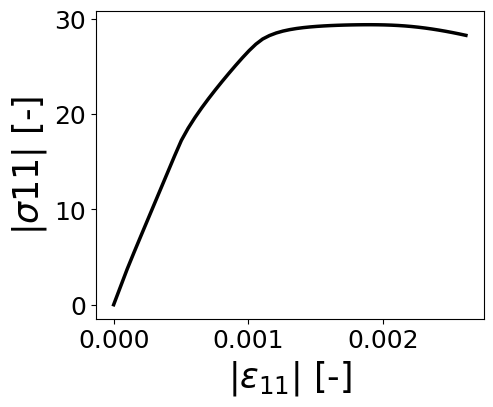

In [7]:
[omega_N_Emn, z_N_Emn, alpha_N_Emn, r_N_Emn, eps_N_p_Emn, sigma_N_Emn, Z_N_Emn, X_N_Emn, Y_N_Emn, omega_T_Emn, z_T_Emn,
 alpha_T_Emna, eps_T_pi_Emna, sigma_T_Emna, Z_T_pi_Emn, X_T_pi_Emna, Y_T_pi_Emn, Disip_omena_N_Emn, Disip_omena_T_Emn,
 Disip_eps_p_N_Emn, Disip_eps_p_T_Emn, Disip_iso_N_Emn, Disip_iso_T_Emn, Disip_kin_N_Emn, Disip_kin_T_Emn] \
    = get_int_var(path, len(F), n_mp)

font = {'family': 'DejaVu Sans',
        'size': 18}

matplotlib.rc('font', **font)


f, (ax2) = plt.subplots(1, 1, figsize=(5, 4))

ax2.plot(np.abs(U[:, 0]), np.abs(F[:, 0]), 'k', linewidth=2.5)
ax2.set_xlabel(r'$|\varepsilon_{11}$| [-]', fontsize=25)
ax2.set_ylabel(r'$|\sigma{11}$| [-]', fontsize=25)

print(np.max(np.abs(F[:, 0])), 'fc')
plt.show()

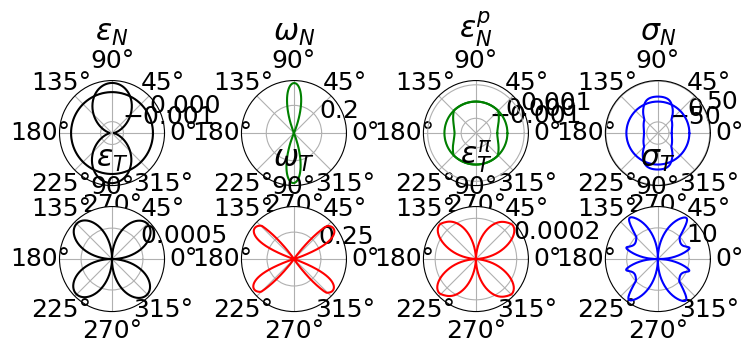

In [8]:
if M_plot == 1:

    # For plotting polar plots, first convert vectorial variables into scalars (by taking norm)

    eps_N_Emn = np.zeros_like(eps_N_p_Emn)
    eps_T_Emna = np.zeros_like(eps_T_pi_Emna)
    eps_T_Emn = np.zeros_like(eps_N_p_Emn)
    eps_T_pi_Emn = np.zeros_like(eps_N_p_Emn)
    sigma_T_Emn = np.zeros_like(eps_N_p_Emn)
    X_T_pi_Emn = np.zeros_like(eps_N_p_Emn)
    alpha_T_Emn = np.zeros_like(eps_N_p_Emn)

    for i in range(len(F)):
        eps = get_eps_ab(U[i])
        eps_N_Emn[i] = m._get_e_N_Emn_2(eps)
        eps = get_eps_ab(U[i])
        eps_T_Emna[i] = m._get_e_T_Emnar_2(eps)

    eps_T_sign_Emn = np.zeros_like(eps_N_p_Emn)
    eps_pi_T = np.zeros_like(eps_N_p_Emn)
    eps_pi_T_sign = np.zeros_like(eps_N_p_Emn)
    sigma_T = np.zeros_like(eps_N_p_Emn)
    sigma_T_sign = np.zeros_like(eps_N_p_Emn)
    X_T = np.zeros_like(eps_N_p_Emn)
    X_T_sign = np.zeros_like(eps_N_p_Emn)

    eps_T_Emn = np.sqrt(np.einsum('...i,...i->... ', eps_T_Emna, eps_T_Emna))
    eps_T_pi_Emn = np.sqrt(np.einsum('...i,...i->... ', eps_T_pi_Emna, eps_T_pi_Emna))
    sigma_T_Emn = np.sqrt(np.einsum('...i,...i->... ', sigma_T_Emna, sigma_T_Emna))
    X_T_pi_Emn = np.sqrt(np.einsum('...i,...i->... ', X_T_pi_Emna, X_T_pi_Emna))
    alpha_T_Emn = np.sqrt(np.einsum('...i,...i->... ', alpha_T_Emna, alpha_T_Emna))

    # plot.get_2Dviz(n_mp, eps_N_Emn, eps_T_Emn, omega_N_Emn, z_N_Emn, alpha_N_Emn, r_N_Emn, eps_N_p_Emn, sigma_N_Emn, Z_N_Emn, X_N_Emn, Y_N_Emn, \
    #        omega_T_Emn, z_T_Emn, alpha_T_Emn, eps_T_pi_Emn, sigma_T_Emn, Z_T_pi_Emn, X_T_pi_Emn, Y_T_pi_Emn, \
    #        Disip_omena_N_Emn, Disip_omena_T_Emn, Disip_eps_p_N_Emn, Disip_eps_p_T_Emn, Disip_iso_N_Emn, \
    #        Disip_iso_T_Emn, Disip_kin_N_Emn, Disip_kin_T_Emn)



    plot.get_2Dviz(eps_N_Emn, eps_T_Emn, omega_N_Emn, eps_N_p_Emn, sigma_N_Emn, \
     omega_T_Emn, eps_T_pi_Emn, sigma_T_Emn)

# Fatigue

In [11]:
def get_UF_t(F, n_t, load, S_max1, S_max2, S_min1, n_mp, loading_scenario):

    # Initialization internal variables and dissipation

    int_var = np.zeros((n_mp,21))
    int_var_aux = np.zeros((n_mp, 21))
    dissip =  np.zeros((n_mp,8))
    save=np.concatenate((int_var,dissip), axis=1)
    df = pd.DataFrame(save)
    df.to_hdf(path, 'first', mode='w', format='table')

    # total number of DOFs
    n_O = 3
    # Global vectors initialization
    F_ext = np.zeros((n_O,), np.float_)
    F_O = np.zeros((n_O,), np.float_)
    U_P = np.zeros((n_O,), np.float_)
    U_k_O = np.zeros((n_O,), dtype=np.float_)
    eps_aux = get_eps_ab(U_k_O)
    # Setup the system matrix with displacement constraints
    # Time stepping parameters
    t_aux, t_n1, t_max, t_step = 0, 0, len(F), 1 / n_t
    # Iteration parameters
    k_max, R_acc = 1000, 1e-3
    # Record solutions
    U_t_list, F_t_list, U_P_list = [np.copy(U_k_O)], [np.copy(F_O)], [np.copy(U_P)]
    D = np.zeros((2, 2, 2, 2))
    D = D[np.newaxis, :, :, :, :]

    # Load increment loop
    while t_n1 <= t_max - 1:
        F_ext[0] = F[t_n1]
        F_ext[1] = 0. * F[t_n1]
        F_ext[2] = 0. * F[t_n1]

        k = 0
        # Equilibrium iteration loop
        while k < k_max:
            # Transform the primary vector to field
            eps_ab = get_eps_ab(U_k_O)
            # Stress and material stiffness

            D_abcd, sig_ab, eps_p_Emab = m.get_corr_pred(
                eps_ab, 1, int_var, eps_aux, F_ext
            )

            # Internal force
            F_O = get_sig_O(sig_ab).reshape(3,)
            U_P = get_sig_O(eps_p_Emab).reshape(3, )
            # Residuum
            R_O = F_ext - F_O
            # System matrix
            K_OP = get_K_OP(D_abcd)
            # Convergence criterion
            R_norm = np.linalg.norm(R_O)
            delta_U_O = np.linalg.solve(K_OP, R_O)
            U_k_O += delta_U_O
            if R_norm < R_acc:
                # Convergence reached
                break
            # Next iteration
            k += 1

        else:
            print('no convergence')
            break

        # Update states variables after convergence
        int_var = m._get_state_variables(eps_ab, int_var, eps_aux)

        # Definition internal variables / forces per column:  1) damage N, 2)iso N, 3)kin N, 4) consolidation N, 5) eps p N,
        # 6) sigma N, 7) iso F N, 8) kin F N, 9) energy release N, 10) damage T, 11) iso T, 12-13) kin T, 14-15) eps p T,
        # 16-17) sigma T, 18) iso F T, 19-20) kin F T, 21) energy release T


        # Definition dissipation components per column: 1) damage N, 2) damage T, 3) eps p N, 4) eps p T, 5) iso N
        # 6) iso T, 7) kin N, 8) kin T

        dissip[:, 0] += np.einsum('...n,...n->...n', int_var[:,0] - int_var_aux[:,0], int_var[:, 8])
        dissip[:, 1] += np.einsum('...n,...n->...n', int_var[:, 9] - int_var_aux[:, 9], int_var[:, 20])
        dissip[:, 2] += np.einsum('...n,...n->...n', int_var[:, 4] - int_var_aux[:, 4], int_var[:, 5])
        dissip[:, 3] += np.einsum('...n,...n->...', int_var[:, 13:15] - int_var_aux[:, 13:15], int_var[:, 15:17])
        dissip[:, 4] += np.einsum('...n,...n->...n', int_var[:, 1] - int_var_aux[:, 1], int_var[:, 6])
        dissip[:, 5] += np.einsum('...n,...n->...n', int_var[:, 10] - int_var_aux[:, 10], int_var[:, 17])
        dissip[:, 6] += np.einsum('...n,...n->...n', int_var[:, 2] - int_var_aux[:, 2], int_var[:, 7])
        dissip[:, 7] += np.einsum('...n,...n->...', int_var[:, 11:13] - int_var_aux[:, 11:13], int_var[:, 18:20])

        int_var_aux = int_var * 1

        if loading_scenario == 'constant':
            # Saving data just at min and max levels
            if F[t_n1] == 0 or F[t_n1] == S_max1 * load or F[t_n1] == S_min1 * load:

                save=np.concatenate((int_var,dissip), axis = 1)

                df = pd.DataFrame(save)
                df.to_hdf(path, 'middle' + np.str(t_aux), append=True)
                U_P_list.append(U_P)
                eps_aux = get_eps_ab(U_k_O)
                D_aux = D_abcd[np.newaxis, :, :, :, :]
                D = np.concatenate((D, D_aux))
                t_aux += 1
            U_t_list.append(np.copy(U_k_O))
            F_t_list.append(F_O)

        if loading_scenario == 'order':
        # Saving data just at min and max levels
            if F[t_n1] == 0 or F[t_n1] == S_max1 * load or F[t_n1] == S_max2 * load or F[t_n1] == S_min1 * load:

                save = np.concatenate((int_var, dissip), axis=1)

                df = pd.DataFrame(save)
                df.to_hdf(path, 'middle' + np.str(t_aux), append=True)

                
                U_P_list.append(U_P)
                eps_aux = get_eps_ab(U_k_O)
                D_aux = D_abcd[np.newaxis, :, :, :, :]
                D = np.concatenate((D, D_aux))
                t_aux += 1
                U_t_list.append(np.copy(U_k_O))
                F_t_list.append(F_O)

        t_n1 += 1

    U_t, F_t, U_p = np.array(U_t_list), np.array(F_t_list),np.array(U_P_list)
    return U_t, F_t, t_n1 / t_max, t_aux, D,U_p

In [12]:
def get_int_var(path, size, n_mp):  # unpacks saved data

    S = np.zeros((len(F), n_mp, 29))

    S[0] = np.array(pd.read_hdf(path, 'first'))

    for i in range(1, size):
        S[i] = np.array(pd.read_hdf(path, 'middle' + np.str(i - 1)))

    omega_N_Emn = S[:, :, 0]
    z_N_Emn = S[:, :, 1]
    alpha_N_Emn = S[:, :, 2]
    r_N_Emn = S[:, :, 3]
    eps_N_p_Emn = S[:, :, 4]
    sigma_N_Emn = S[:, :, 5]
    Z_N_Emn = S[:, :, 6]
    X_N_Emn = S[:, :, 7]
    Y_N_Emn = S[:, :, 8]

    omega_T_Emn = S[:, :, 9]
    z_T_Emn = S[:, :, 10]
    alpha_T_Emna = S[:, :, 11:13]
    eps_T_pi_Emna = S[:, :, 13:15]
    sigma_T_Emna = S[:, :, 15:17]
    Z_T_pi_Emn = S[:, :, 17]
    X_T_pi_Emna = S[:, :, 18:20]
    Y_T_pi_Emn = S[:, :, 20]

    Disip_omena_N_Emn = S[:, :, 21]
    Disip_omena_T_Emn = S[:, :, 22]
    Disip_eps_p_N_Emn = S[:, :, 23]
    Disip_eps_p_T_Emn = S[:, :, 24]
    Disip_iso_N_Emn = S[:, :, 25]
    Disip_iso_T_Emn = S[:, :, 26]
    Disip_kin_N_Emn = S[:, :, 27]
    Disip_kin_T_Emn = S[:, :, 28]

    return omega_N_Emn, z_N_Emn, alpha_N_Emn, r_N_Emn, eps_N_p_Emn, sigma_N_Emn, Z_N_Emn, X_N_Emn, Y_N_Emn, \
           omega_T_Emn, z_T_Emn, alpha_T_Emna, eps_T_pi_Emna, sigma_T_Emna, Z_T_pi_Emn, X_T_pi_Emna, Y_T_pi_Emn, \
           Disip_omena_N_Emn, Disip_omena_T_Emn, Disip_eps_p_N_Emn, Disip_eps_p_T_Emn, Disip_iso_N_Emn, \
           Disip_iso_T_Emn, Disip_kin_N_Emn, Disip_kin_T_Emn

In [13]:
concrete_type= 0        # 0:C40MA, 1:C80MA, 2:120MA, 3:Tensile, 4:Compressive, 5:Biaxial, 6: Paper 2D redistribution

Concrete_Type_string = ['C40MA', 'C80MA','C120MA', 'Tensile', 'Compressive', 'Biaxial', 'Paper_2D']

loading_scenario = 'constant'   # constant, order, increasing

M_plot = 1  # Plot microplanes polar graphs. 1: yes, 0: no

t_steps_cycle = 200
n_mp = 360

S_max1 = 0.9          # maximum loading level
S_min1 = 0.20           # minimum loading level
n_cycles1 = 10         # number of applied cycles

# For sequence order effect

eta1 = 0.15             # fatigue life fraction first level
cycles1 = 1000           # fatigue life first level

S_max2 = 0.9            # maximum loading level second level
cycles2 = 221         # fatigue life second level
n_cycles2 = np.int(1e3 - np.floor(eta1*cycles1)) # number of applied cycles second level


In [14]:
# Path saving data

home_dir = os.path.expanduser('~')

if not os.path.exists('Data Processing'):
    os.makedirs('Data Processing')

path = os.path.join(
   home_dir, 'Data Processing/' + Concrete_Type_string[concrete_type] + loading_scenario + str(S_max1) + str(eta1) + '.hdf5')

In [26]:
# FINAL LOADINGS

# load_options = [-60.54301292467442, -91.69221808121128, -119.33166543189739, 0, 0 , 0, -95.19749064866976]
load_options = [-25.0, -91.69221808121128, -119.33166543189739, 0, 0 , 0, -95.19749064866976]

load = load_options[concrete_type]

# LOADING SCENARIOS

first_load = np.concatenate((np.linspace(0, load * S_max1, t_steps_cycle), np.linspace(
    load * S_max1, load * S_min1, t_steps_cycle)[1:]))

if loading_scenario == 'constant':

    cycle1 = np.concatenate(
        (np.linspace(load * S_min1, load * S_max1, t_steps_cycle)[1:], np.linspace(load * S_max1, load * S_min1, t_steps_cycle)[
                                                              1:]))
    cycle1 = np.tile(cycle1, n_cycles1 - 1)

    sin_load = np.concatenate((first_load, cycle1))


if loading_scenario == 'order':

    cycle1 = np.concatenate(
        (np.linspace(load * S_min1, load * S_max1, t_steps_cycle)[1:], np.linspace(load * S_max1, load * S_min1, t_steps_cycle)[
                                                              1:]))
    cycle1 = np.tile(cycle1, np.int(np.floor(eta1*cycles1)) - 1)

    change_order = np.concatenate((np.linspace(load * S_min1, load * S_max2, 632)[1:], np.linspace(load * S_max2, load * S_min1, 632)[
                                                                              1:]))

    cycle2 = np.concatenate(
        (np.linspace(load * S_min1, load * S_max2, t_steps_cycle)[1:], np.linspace(load * S_max2, load * S_min1, t_steps_cycle)[
                                                              1:]))
    cycle2 = np.tile(cycle2, n_cycles2)

    sin_load = np.concatenate((first_load, cycle1, change_order, cycle2))

In [27]:
t_steps = len(sin_load)
T = 1 / n_cycles1
t = np.linspace(0, 1, len(sin_load))


m = MATS2DMplCSDEEQ(**C40MS1)
plot = Micro2Dplot()

U, F, cyc, number_cyc, D, U_p = get_UF_t(
    sin_load, t_steps, load, S_max1, S_max2, S_min1, n_mp, loading_scenario)

[omega_N_Emn, z_N_Emn, alpha_N_Emn, r_N_Emn, eps_N_p_Emn, sigma_N_Emn, Z_N_Emn, X_N_Emn, Y_N_Emn, omega_T_Emn, z_T_Emn,
 alpha_T_Emna, eps_T_pi_Emna, sigma_T_Emna, Z_T_pi_Emn, X_T_pi_Emna, Y_T_pi_Emn, Disip_omena_N_Emn, Disip_omena_T_Emn,
 Disip_eps_p_N_Emn, Disip_eps_p_T_Emn, Disip_iso_N_Emn, Disip_iso_T_Emn, Disip_kin_N_Emn, Disip_kin_T_Emn] \
    = get_int_var(path, len(F), n_mp)

KeyError: 'No object named middle21 in the file'

22.499801048674733 sigma1
0.0006795845423774871 sigma2


<Figure size 640x480 with 0 Axes>

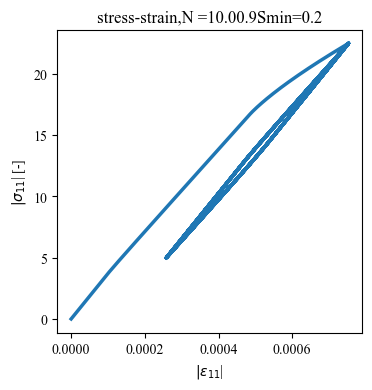

In [28]:
cm = 1/2.54  # centimeters in inches
plt.style.use('default')
N=[]
plt.tight_layout()
plt.rcParams["font.family"] = "Times New Roman"

print(np.max(np.abs(F[:, 0])), 'sigma1')
print(np.max(np.abs(F[:, 1])), 'sigma2')

# Fig 1, stress-strain curve

f, (ax2) = plt.subplots(1, 1, figsize=(10*cm, 10*cm))

ax2.plot(np.abs(U[:, 0]), np.abs(F[:, 0]), linewidth=2.5)
ax2.set_xlabel(r'$|\varepsilon_{11}$|')
ax2.set_ylabel(r'$|\sigma_{11}$| [-]')
ax2.set_title('stress-strain' + ',' + 'N =' + str(cyc*n_cycles1) + str(S_max1) + 'Smin=' + str(S_min1))
f.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\PTST Journal Paper\Figures\\study02\\stress_strain'  + '.pdf')
plt.show()

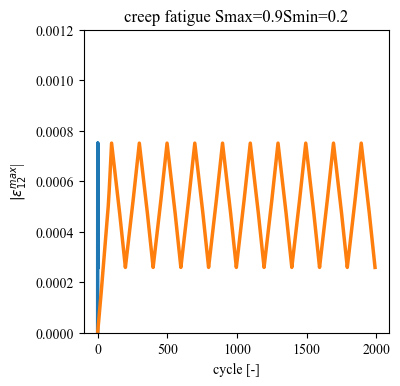

In [29]:
if loading_scenario == 'constant':

    # Fig 2, creep fatigue curve

    f, (ax) = plt.subplots(1, 1, figsize=(10*cm, 10*cm))

    # ax.plot((np.arange(len(U[1::2, 0])) + 1) / len(U[1::2, 0]),
    #         np.abs(U[1::2, 0]), linewidth=2.5)
    
    ax.plot((np.arange(len(U[2::2, 0])) + 1),
            np.abs(U[2::2, 0]), linewidth=2.5)
    
    ax.plot((np.arange(len(U[3::2, 0])) + 1),
            np.abs(U[3::2, 0]), linewidth=2.5)

    ax.set_xlabel(r'cycle [-]')
    ax.set_ylabel(r'$|\varepsilon_{12}^{max}$|')
    ax.set_ylim([0,1.2e-3])
    ax.set_title('creep fatigue Smax=' + str(S_max1) + 'Smin=' + str(S_min1))
    plt.show()
    f.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\PTST Journal Paper\Figures\\study02\\creep_fatigue'  + '.pdf')


if loading_scenario == 'order':

    # Fig 2, Creep Fatigue Curve

    f, (ax) = plt.subplots(1, 1, figsize=(5, 4))

    X_axis1 = np.array(np.arange(eta1 * cycles1) + 1)[:] / cycles1
    #X_axis1 = np.concatenate((np.array([0]), X_axis1))
    Y_axis1 = np.abs(U[3:np.int(2 * eta1 * cycles1) + 2:2, 0])
    # Y_axis1 = np.concatenate((np.array([Y_axis1[0]]), Y_axis1))


    X_axis2 = np.array((np.arange(len(U[2::2, 0]) - (eta1 * cycles1)) + 1) / (cycles2) + eta1)
    X_axis2 = np.concatenate((np.array([X_axis1[-1]]), X_axis2))
    Y_axis2 = np.abs(U[np.int(2 * eta1 * cycles1) + 1::2, 0])
    Y_axis2 = np.concatenate((np.array([Y_axis2[0]]), Y_axis2))

    ax.plot(X_axis1, Y_axis1, 'k', linewidth=2.5)
    ax.plot(X_axis2, Y_axis2, 'k', linewidth=2.5)
    ax.plot([X_axis1[-1], X_axis2[0]], [Y_axis1[-1], Y_axis2[0]], 'k', linewidth=2.5)

    ax.set_ylim(0.002, 0.0045)
    
    ax.set_xlim(-0.1, 1.1)
    ax.set_xlabel('cyccle [-]')
    ax.set_ylabel('strain')
    plt.title('creep fatigue Smax1=' + str(S_max1) + 'Smax2=' + str(S_max2) + 'Smin=' + str(S_min1))
    plt.show()
    
    

In [31]:
if M_plot == 1:

    # For plotting polar plots, first convert vectorial variables into scalars (by taking norm)

    eps_N_Emn = np.zeros_like(eps_N_p_Emn)
    eps_T_Emna = np.zeros_like(eps_T_pi_Emna)
    eps_T_Emn = np.zeros_like(eps_N_p_Emn)
    eps_T_pi_Emn = np.zeros_like(eps_N_p_Emn)
    sigma_T_Emn = np.zeros_like(eps_N_p_Emn)
    X_T_pi_Emn = np.zeros_like(eps_N_p_Emn)
    alpha_T_Emn = np.zeros_like(eps_N_p_Emn)

    for i in range(len(F)):
        eps = get_eps_ab(U[i])
        eps_N_Emn[i] = m._get_e_N_Emn_2(eps)
        eps = get_eps_ab(U[i])
        eps_T_Emna[i] = m._get_e_T_Emnar_2(eps)


    eps_T_sign_Emn = np.zeros_like(eps_N_p_Emn)
    eps_pi_T = np.zeros_like(eps_N_p_Emn)
    eps_pi_T_sign = np.zeros_like(eps_N_p_Emn)
    sigma_T = np.zeros_like(eps_N_p_Emn)
    sigma_T_sign = np.zeros_like(eps_N_p_Emn)
    X_T = np.zeros_like(eps_N_p_Emn)
    X_T_sign = np.zeros_like(eps_N_p_Emn)


    eps_T_Emn = np.sqrt(np.einsum('...i,...i->... ', eps_T_Emna, eps_T_Emna))
    eps_T_pi_Emn = np.sqrt(np.einsum('...i,...i->... ', eps_T_pi_Emna, eps_T_pi_Emna))
    sigma_T_Emn = np.sqrt(np.einsum('...i,...i->... ', sigma_T_Emna, sigma_T_Emna))
    X_T_pi_Emn = np.sqrt(np.einsum('...i,...i->... ', X_T_pi_Emna, X_T_pi_Emna))
    alpha_T_Emn = np.sqrt(np.einsum('...i,...i->... ', alpha_T_Emna, alpha_T_Emna))


#     plot.get_2Dviz(n_mp, eps_N_Emn, eps_T_Emn, omega_N_Emn, z_N_Emn, alpha_N_Emn, r_N_Emn, eps_N_p_Emn, sigma_N_Emn, Z_N_Emn, X_N_Emn, Y_N_Emn, \
#            omega_T_Emn, z_T_Emn, alpha_T_Emn, eps_T_pi_Emn, sigma_T_Emn, Z_T_pi_Emn, X_T_pi_Emn, Y_T_pi_Emn, \
#            Disip_omena_N_Emn, Disip_omena_T_Emn, Disip_eps_p_N_Emn, Disip_eps_p_T_Emn, Disip_iso_N_Emn, \
#            Disip_iso_T_Emn, Disip_kin_N_Emn, Disip_kin_T_Emn)

    plot.get_2Dviz(eps_N_Emn, eps_T_Emn, omega_N_Emn, eps_N_p_Emn, sigma_N_Emn, \
     omega_T_Emn, eps_T_pi_Emn, sigma_T_Emn)

IndexError: index 54 is out of bounds for axis 0 with size 54

In [34]:
eps.shape

(2, 2)

In [155]:
omega_T_Emn[-1].shape

(360,)

[3, 53]


<Figure size 640x480 with 0 Axes>

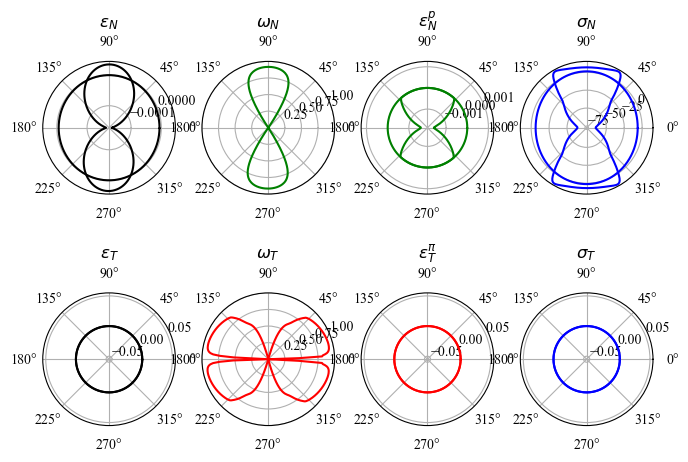

In [36]:
#     def get_2Dviz(n_mp, eps_N_Emn, eps_T_Emn, omega_N_Emn, eps_N_p_Emn, sigma_N_Emn, \
#            omega_T_Emn, eps_T_pi_Emn, sigma_T_Emn):

#     # def get_2Dviz(self, n_mp, eps_N_Emn, eps_T_Emn, omega_N_Emn, z_N_Emn, alpha_N_Emn, r_N_Emn, eps_N_p_Emn,
#     #               sigma_N_Emn, Z_N_Emn, X_N_Emn, Y_N_Emn, \
#     #               omega_T_Emn, z_T_Emn, alpha_T_Emn, eps_T_pi_Emn, sigma_T_Emn, Z_T_pi_Emn, X_T_pi_Emn, Y_T_pi_Emn, \
#     #               Disip_omena_N_Emn, Disip_omena_T_Emn, Disip_eps_p_N_Emn, Disip_eps_p_T_Emn, Disip_iso_N_Emn, \
#     #               Disip_iso_T_Emn, Disip_kin_N_Emn, Disip_kin_T_Emn):
n_mp = 360
rads = np.arange(0, (2 * np.pi), (2 * np.pi) / n_mp)
font = {'family': 'Times New Roman ',
        'size': 10}

plt.tight_layout()
# plt.rcParams["font.family"] = "Times New Roman"

matplotlib.rc('font', **font)
A = np.array(range(len(eps_N_p_Emn[::2])))
# A= A[::10]
A = [3, len(eps_N_p_Emn)-1]
print(A)
plt.figure(figsize=(20*cm, 14*cm))
plt.subplot(241, projection='polar')
for i in A:
    plt.plot(rads, eps_N_Emn[i, :], 'k')
plt.title(r'$\varepsilon_N$')

plt.subplot(242, projection='polar')
for i in A:
    plt.plot(rads, omega_N_Emn[i, :], 'g')
plt.title(r'$\omega_N$')
plt.ylim(0,1)

plt.subplot(243, projection='polar')
for i in A:
    plt.plot(rads, eps_N_p_Emn[i, :], 'g')
plt.ylim(-1.2 * np.max(np.abs(eps_N_p_Emn)),
         0.8 * np.max(np.abs(eps_N_p_Emn)))
plt.title(r'$\varepsilon^p_N$')

plt.subplot(244, projection='polar')
for i in A:
    plt.plot(rads, sigma_N_Emn[i, :], 'b')
plt.ylim(-1.2 * np.max(np.abs(sigma_N_Emn)),
         1.2 * np.max((sigma_N_Emn)))
plt.title(r'$\sigma_N$')

plt.subplot(245, projection='polar')
for i in A:
    plt.plot(rads, np.abs(eps_T_Emn[i, :]), 'k')
plt.title(r'$\varepsilon_T$')

plt.subplot(246, projection='polar')
for i in A:
    plt.plot(rads, omega_T_Emn[i, :], 'r')
plt.title(r'$\omega_T$')
plt.ylim(0,1)

plt.subplot(247, projection='polar')
for i in A:
    plt.plot(rads, np.abs(eps_T_pi_Emn[i, :]), 'r')
plt.title(r'$\varepsilon^{\pi}_T$')

plt.subplot(248, projection='polar')
for i in A:
    plt.plot(rads, np.abs(sigma_T_Emn[i, :]), 'b')
plt.title(r'$\sigma_T$')


plt.show()

